In [70]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
from sklearn.metrics import davies_bouldin_score
from yellowbrick.cluster import KElbowVisualizer

In [72]:
# Load the dataset
file_path = "C:\\Users\\Nirusan03\\PycharmProjects\\MIS710_Course_Work\\LA4PSchools.csv"
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
data.head()


,StudentID,Gender,Year_02,Kinder_Age,Disability,NCCD-Funded,01.SES,02.SES,NumSibling,SiblingOrder,...,HRSIW-01-SOY,Counting-01,Counting-02,Place Value-01,Place Value-02,Addition and Subtraction-01,Addition and Subtraction-02,Multiplication and Division-01,Multiplication and Division-02,Year3_Writing_At_Risk
0,SN35433053,Male,2020,5.5,Disability_Non-disable,0,104,104,3,3,...,49,4,5,2,2,2,4,2,2,False
1,SN71277215,Female,2018,5.8,Disability_Non-disable,0,112,112,2,2,...,37,2,1,1,1,2,3,0,2,False
2,SN40883127,Male,2021,5.9,Disability_Non-disable,0,120,109,2,2,...,30,2,1,1,2,2,1,2,1,False
3,SN93063777,Male,2021,5.7,Disability_Non-disable,0,95,93,2,1,...,30,2,3,1,2,1,5,2,2,False
4,SN84195329,Male,2021,5.8,Disability_Non-disable,0,98,98,1,1,...,32,2,4,2,2,2,4,1,1,True


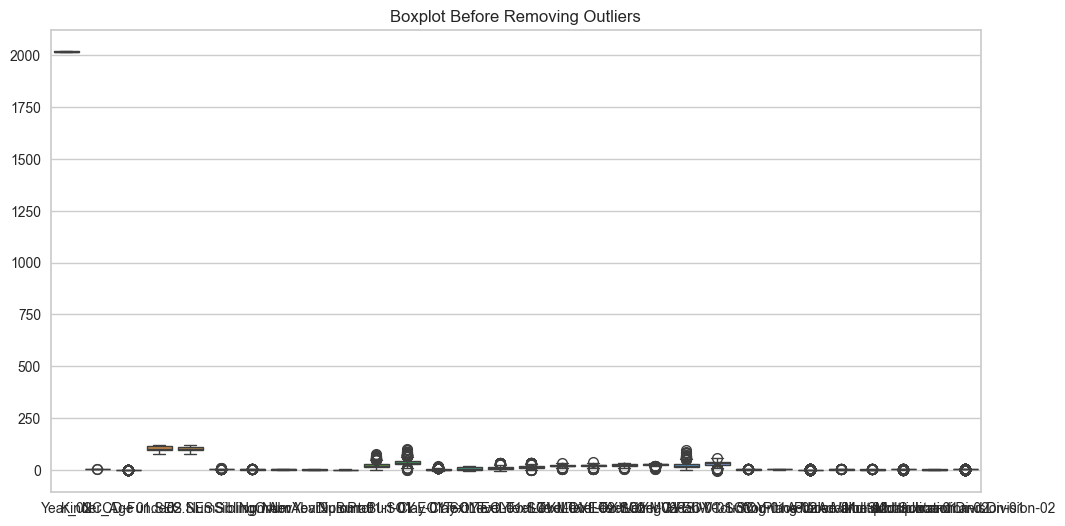

In [73]:
# Visualize Boxplot before removing outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=data.select_dtypes(include=[np.number]))  # Boxplot for numeric columns only
plt.title('Boxplot Before Removing Outliers')
plt.show()


In [74]:
# Handle outliers using the IQR method
def handle_outliers(data):
    outlier_count = 0
    for col in data.select_dtypes(include=[np.number]).columns:  # Only handle numeric columns
        q1 = data[col].quantile(0.25)
        q3 = data[col].quantile(0.75)
        iqr = q3 - q1
        upper_bound = q3 + 1.5 * iqr
        lower_bound = q1 - 1.5 * iqr
        outliers = ((data[col] < lower_bound) | (data[col] > upper_bound))
        outlier_count += outliers.sum()
        data = data[~outliers]  # Remove outliers
    
    print(f"Total outliers removed: {outlier_count}")
    return data

# Handle outliers and display the result
data_clean = handle_outliers(data)

# Show the first few rows of the dataset after removing outliers
data_clean.head()


Total outliers removed: 1529


,StudentID,Gender,Year_02,Kinder_Age,Disability,NCCD-Funded,01.SES,02.SES,NumSibling,SiblingOrder,...,HRSIW-01-SOY,Counting-01,Counting-02,Place Value-01,Place Value-02,Addition and Subtraction-01,Addition and Subtraction-02,Multiplication and Division-01,Multiplication and Division-02,Year3_Writing_At_Risk
6,SN00499342,Male,2020,5.1,Disability_Non-disable,0,110,110,2,1,...,51,2,2,1,1,0,2,0,2,False
10,SN32145676,Male,2017,4.8,Disability_Non-disable,0,116,116,2,2,...,34,1,3,1,1,1,2,2,2,False
17,SN31301883,Male,2020,5.0,Disability_Cognitive,0,102,102,3,2,...,39,1,2,1,3,1,3,2,2,False
18,SN33074201,Female,2018,5.5,Disability_Non-disable,0,92,92,3,1,...,26,2,3,1,1,2,2,2,2,False
21,SN94638647,Male,2017,5.8,Disability_SocialEmotional,0,97,97,1,1,...,24,2,4,1,2,2,2,0,2,False


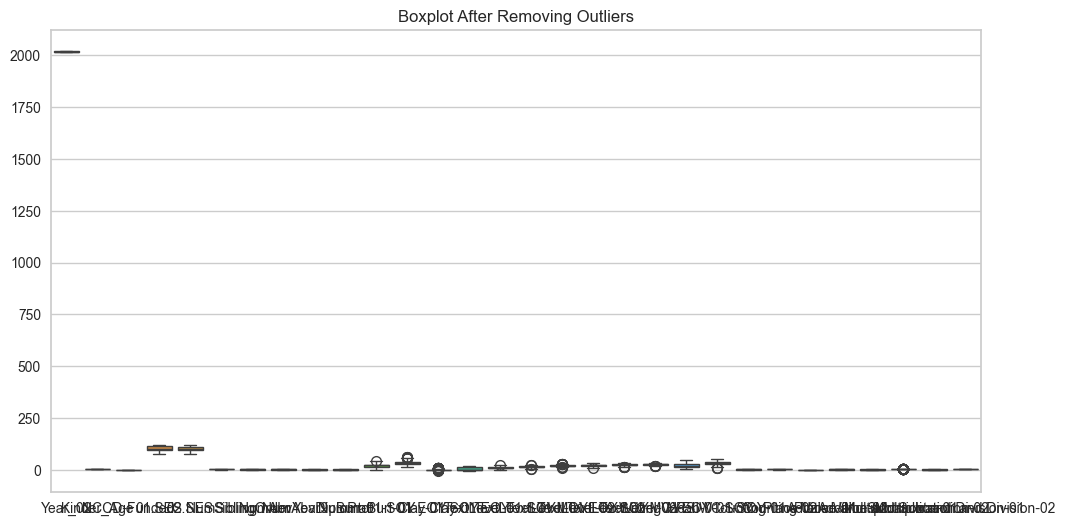

In [75]:
# Visualize Boxplot after removing outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=data_clean.select_dtypes(include=[np.number]))  # Boxplot for numeric columns only
plt.title('Boxplot After Removing Outliers')
plt.show()


In [76]:
# Preprocess the dataset (One-Hot Encoding and Scaling)
def preprocess_data(data):
    # One-hot encoding for categorical variables
    categorical_features = ['Gender', 'Disability']
    data_encoded = pd.get_dummies(data, columns=categorical_features, drop_first=True)

    # Remove unnecessary columns (e.g., 'StudentID', 'Year3_Writing_At_Risk') to create the feature set
    X = data_encoded.drop(columns=['StudentID', 'Year3_Writing_At_Risk'])

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Return the scaled features and the original dataset without 'StudentID'
    return X_scaled, X.columns

# Preprocess the data
X_scaled, columns = preprocess_data(data_clean)

# Display the first few rows of the scaled dataset, aligning it with the original feature names
pd.DataFrame(X_scaled, columns=columns).head()


,Year_02,Kinder_Age,NCCD-Funded,01.SES,02.SES,NumSibling,SiblingOrder,NumAbvYear9,NumAbvDiploma,NumProf,...,Place Value-02,Addition and Subtraction-01,Addition and Subtraction-02,Multiplication and Division-01,Multiplication and Division-02,Gender_Male,Disability_Disability_Non-disable,Disability_Disability_Physical,Disability_Disability_Sensory,Disability_Disability_SocialEmotional
0,0.803321,-0.454774,0.0,0.723471,0.834425,-0.337432,-0.911660,0.605636,1.310287,1.444410,...,-1.241895,-1.641672,-0.574899,-1.354081,0.0,1.095872,0.519174,-0.193507,-0.065302,-0.161690
1,-0.989875,-1.335043,0.0,1.370679,1.490542,-0.337432,0.491581,0.605636,1.310287,1.444410,...,-1.241895,-0.313102,-0.574899,1.113122,0.0,1.095872,0.519174,-0.193507,-0.065302,-0.161690
2,0.803321,-0.748197,0.0,-0.139473,-0.040398,0.913989,0.491581,0.605636,0.130277,0.233881,...,2.556368,-0.313102,1.739437,1.113122,0.0,1.095872,-1.926136,-0.193507,-0.065302,-0.161690
3,-0.392143,0.718917,0.0,-1.218152,-1.133926,0.913989,-0.911660,0.605636,-1.049733,1.444410,...,-1.241895,1.015467,-0.574899,1.113122,0.0,-0.912516,0.519174,-0.193507,-0.065302,-0.161690
4,-0.989875,1.599185,0.0,-0.678812,-0.587162,-1.588853,-0.911660,-2.150447,-1.049733,-0.976648,...,0.657237,1.015467,-0.574899,-1.354081,0.0,1.095872,-1.926136,-0.193507,-0.065302,6.184658


In [77]:
# Perform PCA (Principal Component Analysis)
def perform_pca(X_scaled):
    pca = PCA()
    pca_transformed = pca.fit_transform(X_scaled)

    # Eigenvalues (Variance explained by each PC)
    eigenvalues = pca.explained_variance_
    print("\nEigenvalues (Variance explained by each PC):")
    print(eigenvalues)

    # Eigenvectors (Principal Components)
    eigenvectors = pca.components_
    print("\nEigenvectors (Principal Components):")
    print(eigenvectors)

    # Cumulative variance explained by PCA
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_) * 100
    print("\nCumulative Variance Explained by PCA:")
    print(cumulative_variance)

    return pca_transformed

# Perform PCA on scaled data
pca_transformed = perform_pca(X_scaled)

# Show the first two components of PCA for visualization
pd.DataFrame(pca_transformed[:, :2], columns=["PC 1", "PC 2"]).head()



Eigenvalues (Variance explained by each PC):
[5.97445819e+00 2.53242583e+00 1.93316285e+00 1.69439414e+00
 1.64876658e+00 1.49312411e+00 1.39724204e+00 1.20528799e+00
 1.12200719e+00 1.03944530e+00 1.01377457e+00 9.49770858e-01
 8.92933828e-01 8.82266807e-01 8.18599302e-01 7.78757168e-01
 7.41348633e-01 6.94079415e-01 6.13776240e-01 5.79359037e-01
 5.21874115e-01 4.75623237e-01 4.51383285e-01 4.15584402e-01
 3.98232140e-01 3.80922003e-01 3.34711562e-01 3.28422675e-01
 2.69281312e-01 2.40432353e-01 2.15276736e-01 3.13612079e-02
 1.17825412e-30 2.91578158e-32 2.91578158e-32]

Eigenvectors (Principal Components):
[[-3.37675933e-02 -2.05819336e-03 -0.00000000e+00 ... -3.32075726e-02
   5.97665265e-03  4.99257206e-02]
 [ 1.76131679e-02  3.41687080e-02  4.51028104e-17 ... -3.45665546e-02
  -4.19383469e-02 -1.84798963e-02]
 [-2.21593425e-01  5.79465310e-02  1.80411242e-16 ... -1.61907759e-02
  -3.61232518e-02  5.36328849e-02]
 ...
 [-1.22255155e-16 -1.42032753e-18  1.00000000e+00 ...  1.4546

,PC 1,PC 2
0,-2.340230,1.365235
1,-1.854657,2.245274
2,3.054554,1.422102
3,-0.104572,-1.067265
4,2.769296,-2.035042


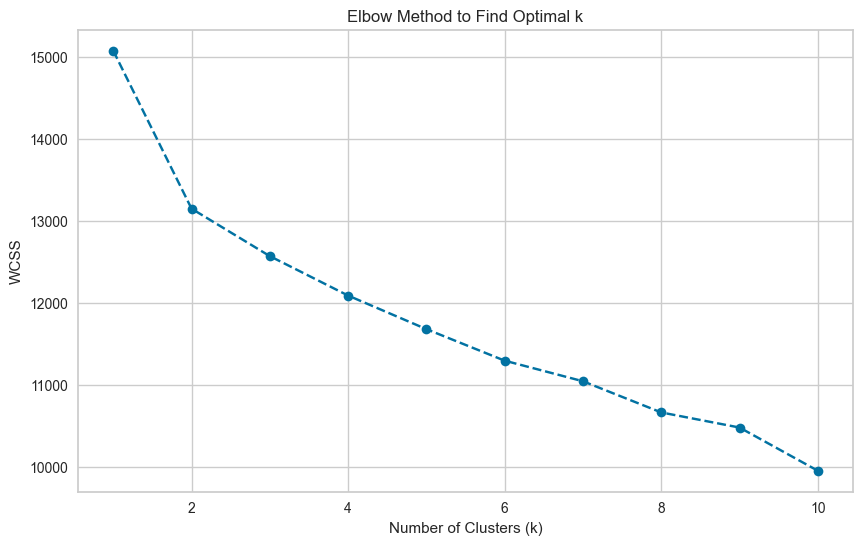

In [78]:
# Plot the Elbow Method to find the optimal number of clusters
def plot_elbow_method(X_scaled):
    wcss = []  # Within-cluster sum of squares
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, random_state=42)
        kmeans.fit(X_scaled)
        wcss.append(kmeans.inertia_)

    # Plot the Elbow graph
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
    plt.title('Elbow Method to Find Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('WCSS')
    plt.show()

# Plot elbow method
plot_elbow_method(X_scaled)



Silhouette Score for k=3: 0.0636782267717547


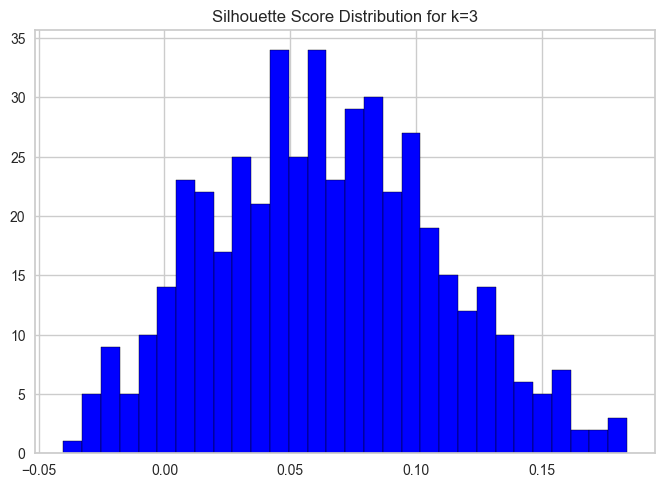

In [62]:
# Perform silhouette analysis to evaluate cluster quality
def silhouette_analysis(X_scaled, optimal_k):
    # Set n_init=10 explicitly to avoid the FutureWarning
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)  
    cluster_labels = kmeans.fit_predict(X_scaled)

    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    print(f"\nSilhouette Score for k={optimal_k}: {silhouette_avg}")

    # Visualize silhouette values
    silhouette_values = silhouette_samples(X_scaled, cluster_labels)
    plt.hist(silhouette_values, bins=30, color='blue', edgecolor='black')
    plt.title(f'Silhouette Score Distribution for k={optimal_k}')
    plt.show()

    return cluster_labels

# Perform silhouette analysis for the chosen k
optimal_k = 3  # Update this based on your Elbow Method result
cluster_labels = silhouette_analysis(X_scaled, optimal_k)


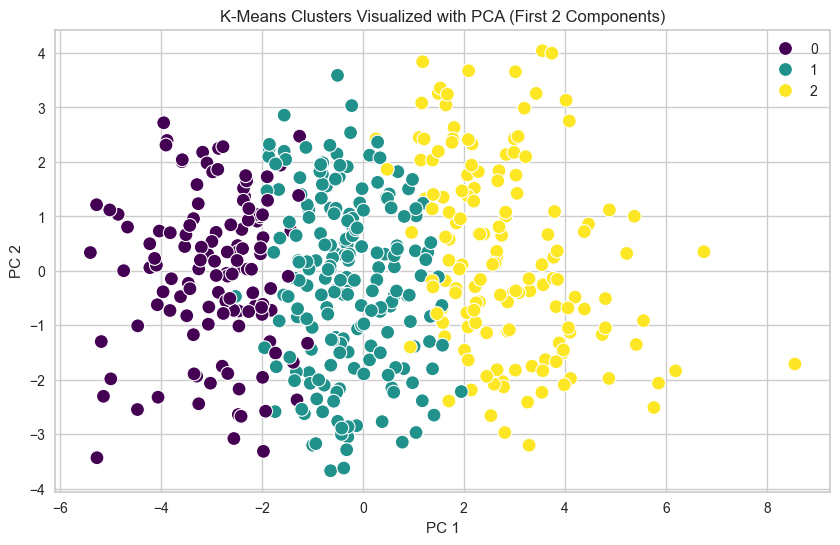

In [67]:
# Visualize clusters using PCA (First 2 Principal Components)
def visualize_clusters_pca(pca_transformed, cluster_labels):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=pca_transformed[:, 0], y=pca_transformed[:, 1], hue=cluster_labels, palette="viridis", s=100)
    plt.title('K-Means Clusters Visualized with PCA (First 2 Components)')
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.show()

# Visualize clusters
visualize_clusters_pca(pca_transformed, cluster_labels)


In [69]:
data_encoded = pd.get_dummies(data, columns=['Gender', 'Disability'], drop_first=True)

# Step 2: Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_encoded.drop(columns=['StudentID', 'Year3_Writing_At_Risk']))

# Step 3: Apply KMeans
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# Step 4: Add the cluster labels to the original dataframe
data_encoded['Cluster'] = cluster_labels
data_encoded[['StudentID', 'Cluster']].head()  # Display the first few rows to check the clusters

# Optionally, save the clustered data to a file
data_encoded.to_excel("schools_clustered.xlsx", index=False)
print("Clustered data saved to 'schools_clustered.xlsx'.")

Clustered data saved to 'schools_clustered.xlsx'.


In [ ]:
### 1. SES Backgrounds of Students (Year 1 and Year 2)
### - Based on the analysis of SES distribution, the students’ SES scores vary around [SES average]. Year 1 and Year 2 have [comparison to national averages].

### 2. Burt Reading Scores (Year 1 and Year 2)
### - The analysis shows that Burt Reading Scores generally [improve/remain the same/decline] from the start to the end of Year 1 and Year 2. There is [some/no] improvement.

### 3. Writing Skills in Year 1 and Risk (Logistic Regression)
### - Logistic Regression results indicate a strong relationship between WritingVocab-01-SOY and Year3_Writing_At_Risk, with low writing scores increasing the likelihood of being at risk.

### 4. Literacy and Numeracy Skills (Correlation)
### - Literacy and Numeracy are [strongly/moderately] correlated. Students with high literacy scores generally have high numeracy scores, and both affect Year3_Writing_At_Risk.

### 5. Disability and Writing At-Risk (Random Forest)
### - Disability conditions show a [significant/small] relationship with Year3_Writing_At_Risk. Students with disabilities are [more/less] likely to be at risk of underperforming in writing.

### 6. Insights for Early Interventions (K-Means)
### - K-Means clustering reveals distinct groups of students based on their writing and reading skills. These clusters suggest that [specific group] needs targeted interventions to improve their writing skills.